In [6]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pydotplus
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import clear_output
from matplotlib import style
style.use('ggplot')

In [2]:
df = pd.read_excel('../final_data.xlsx')
df=df.iloc[:,1:]
df_org = df.copy()
df.head(3)

,Duration,Resource Cost,Fixed Cost,Cost/Hour,Variable Cost,Total Cost,Actual Cost
0,3.0,2400.0,0.0,0.0,0.0,2400.0,2400.0
1,1.0,800.0,0.0,0.0,0.0,800.0,800.0
2,1.0,440.0,0.0,0.0,0.0,440.0,440.0


In [50]:
#Standardization or Normalization
for column in df.columns:
    df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(-1,1))
df.head(10)

In [3]:
# setting x and y
X = df.drop('Actual Cost',axis=1)
# X = df[['Duration','Total Cost']]
y = df['Actual Cost']
# preparing test and train
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=41
)

In [12]:
def generate_metrics(model):
    cr_score = -cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_percentage_error',cv=3)
    model.fit(X_train,y_train)
    train_r2 = model.score(X_train,y_train)
    test_r2 = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    error_MAE = MAE(y_pred,y_test)
    error_MSE = MSE(y_test,y_pred)
    error_MAPE = MAPE(y_test,y_pred)
    return cr_score,train_r2,test_r2,error_MAE,error_MSE,error_MAPE
def print_metrics(cr,tr_R,ts_R,mae,mse,mape):
    print("Cross-Validation-Score:"+str(np.average(cr)))
    print("MAE: "+str(mae))
    print('MSE: '+str(mse))
    print("Train R2: "+ str(tr_R))
    print("Test R2: "+ str(ts_R))
    print("MAPE: "+ str(mape))
def plot_mae(x,cr,mae,x_label):
    min_x = x[mae.index(min(mae))]
    min_y = min(mae)
    min_cr_x = x[cr.index(min(cr))]
    min_cr_y = min(cr)
    fig = plt.figure()
    plt.title('Random Forest HyperParameter OPT')
    plt.xlabel(x_label)
    plt.ylabel("error")
    plt.plot(x,cr,c='green',label='Cross-Val')
    plt.plot(x,mae,c='red',label='Test-MAPE')
    plt.plot(min_x,min_y,'oy',markersize=12)
    plt.annotate("("+str(min_x)+', '+str(round(min_y,3))+")",xy=(min_x,min_y))
    # plt.plot(min_cr_x,min_cr_y,'oy',markersize=12)
    # plt.annotate("("+str(round(min_cr_x,2))+', '+str(round(min_cr_y,3))+")",xy=(min_cr_x,min_cr_y))
    plt.legend()
    plt.savefig('pics_mape/'+x_label+'.png')
    plt.show()

****** 20/20 ******
0.0
0.6820362141135428


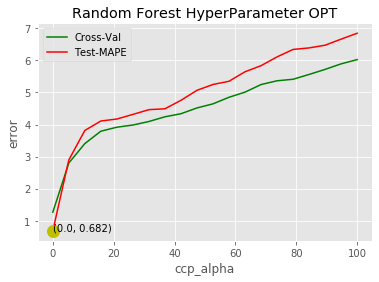

In [32]:
# -------------------------- For Tuning
n_estimators = np.linspace(2,100,50,endpoint=True,dtype=int)
max_depth = np.linspace(2,30,20,endpoint=True,dtype=int)
min_samples_split = np.linspace(2,20,10,endpoint=True,dtype=int)
min_samples_leaf = np.linspace(1,20,10,endpoint=True,dtype=int)
max_samples = np.linspace(0,1,10,endpoint=False)[1:]
max_leaf_nodes = np.linspace(1200,1800,50,endpoint=True,dtype=int)
ccp_alpha = np.linspace(0,100,20,endpoint=True)
min_impurity_decrease = np.linspace(0,100,20,endpoint=True,dtype=int)
name_parameter = 'ccp_alpha'
parameter = ccp_alpha
couunter = 1
cr_list = []
mape_list = []
for i in parameter:
# --------------------------
    rf_reg = RandomForestRegressor(
        ccp_alpha=i,
        random_state=41,
        n_jobs=-3
    )
# -------------------------- For Tuning
    cr,tr_R,ts_R,mae,mse,mape = generate_metrics(rf_reg)
    cr_list.append(np.average(cr))
    mape_list.append(mape)
    if couunter % 10 == 0:
        clear_output(wait=True)
    print("****** " + str(couunter)+'/'+str(len(parameter))+" ******")
    couunter+=1
print(parameter[mape_list.index(min(mape_list))])
print(min(mape_list))
plot_mae(parameter,cr_list,mape_list,x_label=name_parameter)
# --------------------------
# -------------------------- For Single Usage
# print_metrics(cr,tr_R,ts_R,mae,mse,mape)
# --------------------------

### Base Model (with no hyper parameters) <br>
Cross-Validation-Score:6722.2538661331755 <br>
MAE: 6737.619346774119 <br>
MSE: 834961536.3497431 <br>
Train R2: 0.9753240104772036 <br>
Test R2: 0.901266912677243 <br>
#### BEST n_estimators = 431
##### MAE = 6677.9004
#### BEST max_depth = 8
##### MAE = 6542.21106909439
#### BEST min_samples_split = 11
##### MAE = 6334.272018314098
#### BEST min_samples_leaf = 4
##### MAE = 6646.574520190334
#### BEST max_leaf_nodes = 82
##### MAE = 6657.579062504648
#### BEST min_impurity_decrease = 119.83967935871743
##### MAE = 6665.3817623617915
#### BEST bootstrap = True
#### BEST max_samples = 0.2872
##### MAE = 6366.429999261024
#### BEST ccp_alpha = 39000
##### MAE = 6664.685305700229
### Model After Exploratory Parameter Tuning
Cross-Validation-Score:6187.574146749767 <br>
MAE: 6754.023327697424 <br>
MSE: 1117927225.6733496 <br>
Train R2: 0.8898011437878731 <br>
Test R2: 0.8678065975644409
### Final Model
random_state=41,
n_estimators=1000,
max_depth=7,
min_samples_split=9,
min_samples_leaf=3,
max_leaf_nodes=None,
min_impurity_decrease=119.83967,
bootstrap=True,
max_samples=0.4,
ccp_alpha=39000
Cross-Validation-Score:5879.544732601455 <br>
#### With two attrs
MAE: 6543.527372424886 <br>
MSE: 957089051.0565326 <br>
Train R2: 0.9016946498240161 <br>
Test R2: 0.8868254970561454 <br>
#### with all attrs
Cross-Validation-Score:6238.058009386623
MAE: 5644.106595763625
MSE: 833369576.0076303
Train R2: 0.9212834898498198
Test R2: 0.8039321740885634

## Trying to find the best hyper paramteters

In [34]:
# Randomized Search
n_estimators=np.linspace(2,200,50,dtype=int)
max_depth=np.linspace(20,40,20,dtype=int)
min_samples_split=[2]
min_samples_leaf=[1]
max_leaf_nodes = np.linspace(1300,1500,50,dtype=int)
min_impurity_decrease=[0]
max_samples=np.linspace(0.8,1,20,endpoint=False)
ccp_alpha=[0]
random_state = [41]
random_grid = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'max_leaf_nodes':max_leaf_nodes,
    'max_samples':max_samples,
    'ccp_alpha':ccp_alpha,
    'min_impurity_decrease':min_impurity_decrease,
    'random_state': random_state
}
rf_reg = RandomForestRegressor()
random_search = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=random_grid,
    n_iter=500,
    cv=3,
    random_state=42,
    n_jobs=-3,
    verbose=2,
    scoring='neg_mean_absolute_percentage_error')
random_search.fit(X_train,y_train)
print("done")

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
done


In [35]:
-random_search.best_score_

1.0646332406425996

In [36]:
random_search.best_params_

{'random_state': 41,
 'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_samples': 0.8200000000000001,
 'max_leaf_nodes': 1304,
 'max_depth': 35,
 'ccp_alpha': 0}

In [37]:
y_pred = random_search.best_estimator_.predict(X_test)
MAPE(y_test,y_pred)

0.8509978507811113

In [38]:
# Grid Search
n_estimators=[4,100,10]
max_depth=[None,35,27]
min_samples_split=[2]
min_samples_leaf=[1]
max_leaf_nodes=[None,1395,1304]
min_impurity_decrease=[0]
max_samples=[None,0.82,0.9]
ccp_alpha=[0]
random_state = [41]
search_grid = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'max_leaf_nodes':max_leaf_nodes,
    'max_samples':max_samples,
    'ccp_alpha':ccp_alpha,
    'min_impurity_decrease':min_impurity_decrease,
    'random_state': random_state
}
rf_reg = RandomForestRegressor()
search = GridSearchCV(
    estimator=rf_reg,
    param_grid=search_grid,
    cv=3,
    n_jobs=-3,
    verbose=2,
    scoring='neg_mean_absolute_percentage_error')
search.fit(X_train,y_train)
print("done")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
done


In [39]:
-search.best_score_

1.0646332406425996

In [40]:
search.best_params_

{'ccp_alpha': 0,
 'max_depth': None,
 'max_leaf_nodes': 1395,
 'max_samples': 0.82,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10,
 'random_state': 41}

In [41]:
y_pred = search.best_estimator_.predict(X_test)
MAPE(y_test,y_pred)

0.8509978507811113

#FINAL MODEL

In [42]:
mae = []
mape = []
mse = []
for i in range(1,20):
    print('****'+str(i)+'****')
    X = df.drop('Actual Cost',axis=1)
    y = df['Actual Cost']
    X_train,X_test,y_train,y_test = train_test_split(
        X,y,test_size=0.2)
    rf_reg = search.best_estimator_
    rf_reg.fit(X_train,y_train)
    y_pred = rf_reg.predict(X_test)
    mae.append(MAE(y_test,y_pred))
    mse.append(MSE(y_test,y_pred))
    mape.append(MAPE(y_test,y_pred))
print(np.average(mae))
print(np.average(mse))
print(np.average(mape))


****1****
****2****
****3****
****4****
****5****
****6****
****7****
****8****
****9****
****10****
****11****
****12****
****13****
****14****
****15****
****16****
****17****
****18****
****19****
5452.757447050508
459464972.48970693
1.0382000679315062


the mean mae after running for 100 times: 5842.266615793431

In [76]:
MAE_MSP = MAE(df['Actual Cost'],df['Total Cost'])
print("MAE MSP:")
print(MAE_MSP)
MSE_MSP = MSE(df['Actual Cost'],df['Total Cost'])
print("MSE MSP:")
print(MSE_MSP)
MAPE_MSP = MAPE(df['Actual Cost'],df['Total Cost'])
print("MAPE MSP:")
print(MAPE_MSP)

MAE MSP:
3864.3625628316436
MSE MSP:
350210683.9717696
MAPE MSP:
0.741589091679601


In [29]:
# Saving Tree Graph
# dot_data = tree.export_graphviz(tree_regressor, out_file=None, 
#                                 feature_names=['Duration','Total Cost'],class_names=['Acutal Cost'])
# graph = pydotplus.graph_from_dot_data(dot_data)  
# graph.write_svg("tree.svg")

In [30]:
# Saving model
pkl_filename = "tree.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(tree_regressor, file)

In [9]:
pkl_filename = "tree.pkl"
with open(pkl_filename,'rb') as file:
    model = pickle.load(file)
print("MODEL IMPORTED!")
